# Analysis of ROI and Markets in Film

## Overview

This analysis takes data from [IMDb](https://www.imdb.com/) and [The Numbers](https://www.the-numbers.com/) and explores relationships between types of movies and their financials to find out what makes a movie successful. The goal of this study is to provide a hypothetical business with concrete recommendations for the new movie production studio they rolled out. 

Through the data and statistical analysis, it is clear that with ROI (Return on Investment) as the main KPI, certain genres consistently perform better than others and certain characteristics of those genres drive strong ROI. 

#### The two types of markets targeted are:
- Audiences interested in Lighthearted films
    - Musical
    - Animation
    - Family
- Audiences interested in Dark or Heavy films
    - Horror
    - Mystery
    - Thriller
  
#### The suggested runtimes for these categories:
- Dark Films: 80-100 minutes
- Light Films: 140-160 minutes

#### Finally, there was a statistically weak correlation between the average audience rating of a given film and its ROI, showing that the quality of a given film is less important than the quanitity of these films being made when it comes to optimizing for ROI.

## Business Understanding

$$\dfrac{Total Gross - Production Budget}{Production Budget}=ROI$$

The use of ROI allows for variability in the budget of a given film and focuses on consistent financial gain for the film studio. This appeals to a long term approach that minimizes risk and maximizes returns over the course of many films.

## Data Understanding and Preparation

The IMDb data was a zipped SQL Database and The Numbers data came as a zipped csv file.

In [1]:
# Imports here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import zipfile
import os
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:
# Create variables
imdb_filepath = "Data/im.db.zip"
extract_to_data = "Data"

# Open the zip file
with zipfile.ZipFile(imdb_filepath, 'r') as zip_ref:
    # Extract all the contents into the directory
    zip_ref.extractall(extract_to_data)

In [4]:
# Create connection
con = sqlite3.connect('Data/im.db')

In [5]:
# Print Table Schema
imdb_schema = pd.read_sql("""

SELECT *
FROM sqlite_master

""", con)
imdb_schema

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [7]:
# Explore Movie Basics and Movie Ratings tables
pd.read_sql("""

SELECT *
FROM movie_basics

""", con)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [8]:
pd.read_sql("""

SELECT *
FROM movie_ratings

""", con)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


In [9]:
# Join tables on Movie.id and subset only to movies with over 5000 votes
rating_info_comb_5k = pd.read_sql("""

SELECT *
FROM movie_basics AS b
    JOIN movie_ratings AS r
        ON b.movie_id = r.movie_id
WHERE numvotes > 5000

""", con)
rating_info_comb_5k

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,movie_id,averagerating,numvotes
0,tt1043726,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",tt1043726,4.2,50352
1,tt1171222,Baggage Claim,Baggage Claim,2013,96.0,Comedy,tt1171222,5.1,8296
2,tt1181840,Jack and the Cuckoo-Clock Heart,Jack et la mécanique du coeur,2013,94.0,"Adventure,Animation,Drama",tt1181840,7.0,5494
3,tt1210166,Moneyball,Moneyball,2011,133.0,"Biography,Drama,Sport",tt1210166,7.6,326657
4,tt1212419,Hereafter,Hereafter,2010,129.0,"Drama,Fantasy,Romance",tt1212419,6.5,87288
...,...,...,...,...,...,...,...,...,...
3916,tt7772580,The Perfection,The Perfection,2018,90.0,"Drama,Horror,Thriller",tt7772580,6.2,13573
3917,tt8041276,Paddleton,Paddleton,2019,89.0,"Comedy,Drama",tt8041276,7.2,5947
3918,tt8130968,Badla,Badla,2019,118.0,"Crime,Drama,Mystery",tt8130968,8.1,9988
3919,tt8439854,Lust Stories,Lust Stories,2018,120.0,"Drama,Romance",tt8439854,6.6,7691


Now we have a pandas dataframe that has 9 columns that include movie information like name, runtime, genre, and rating info. After subsetting to 5000 votes or more, we have 3921 rows of movies.

In [11]:
# Import and take a look at The Numbers csv
tn_movie_budgets_df = pd.read_csv("Data/tn.movie_budgets.csv")
tn_movie_budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [13]:
tn_movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [17]:
# The financial data is an object due to the dollar sign and commas
# Let's remove that so we can use it for calculations
tn_movie_budgets_df["production_budget"] = tn_movie_budgets_df["production_budget"].replace('[\$,]', '', regex=True).astype(int)

In [18]:
tn_movie_budgets_df["domestic_gross"] = tn_movie_budgets_df["domestic_gross"].replace('[\$,]', '', regex=True).astype(int)

In [19]:
tn_movie_budgets_df["worldwide_gross"] = tn_movie_budgets_df["worldwide_gross"].replace('[\$,]', '', regex=True).astype(int)

In [20]:
# Create a net revenue column
tn_movie_budgets_df['net_revenue'] = tn_movie_budgets_df["worldwide_gross"] - tn_movie_budgets_df["production_budget"]

In [21]:
# Create an ROI column
tn_movie_budgets_df['ROI%'] = tn_movie_budgets_df['net_revenue'] / tn_movie_budgets_df["production_budget"]

In [22]:
# Rename the primary title column to join with The Numbers dataframe
rating_info_comb_5k.rename(columns={'primary_title':'movie'}, inplace=True)

# Merge the two dataframes on movie name
info_budget_df = pd.merge(rating_info_comb_5k, tn_movie_budgets_df, on='movie')

In [23]:
info_budget_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1528 entries, 0 to 1527
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           1528 non-null   object 
 1   movie              1528 non-null   object 
 2   original_title     1528 non-null   object 
 3   start_year         1528 non-null   int64  
 4   runtime_minutes    1528 non-null   float64
 5   genres             1528 non-null   object 
 6   movie_id           1528 non-null   object 
 7   averagerating      1528 non-null   float64
 8   numvotes           1528 non-null   int64  
 9   id                 1528 non-null   int64  
 10  release_date       1528 non-null   object 
 11  production_budget  1528 non-null   int64  
 12  domestic_gross     1528 non-null   int64  
 13  worldwide_gross    1528 non-null   int64  
 14  net_revenue        1528 non-null   int64  
 15  ROI%               1528 non-null   float64
dtypes: float64(3), int64(7),

After the join, we have 1528 rows with movie info, rating info and financial info.

In [24]:
# Drop columns outside of the scope for analysis
info_budget_df.drop(columns=['movie_id', 'original_title', 'id', 'start_year', 'release_date'], inplace=True)

In [25]:
info_budget_df.head()

,movie,runtime_minutes,genres,averagerating,numvotes,production_budget,domestic_gross,worldwide_gross,net_revenue,ROI%
0,The Legend of Hercules,99.0,"Action,Adventure,Fantasy",4.2,50352,70000000,18848538,58953319,-11046681,-0.157810
1,Baggage Claim,96.0,Comedy,5.1,8296,8500000,21569509,22885836,14385836,1.692451
2,Moneyball,133.0,"Biography,Drama,Sport",7.6,326657,50000000,75605492,111300835,61300835,1.226017
3,Hereafter,129.0,"Drama,Fantasy,Romance",6.5,87288,50000000,32746941,108660270,58660270,1.173205
4,21 Jump Street,109.0,"Action,Comedy,Crime",7.2,477771,42000000,138447667,202812429,160812429,3.828867


In [26]:
# Check for duplicates
duplicates = info_budget_df[info_budget_df.groupby(['movie', 'runtime_minutes', 'genres'])['production_budget'].transform('count') > 1]

print(f'{len(duplicates)}: {duplicates}')

110:                           movie  runtime_minutes                    genres  \
50               The Karate Kid            140.0       Action,Drama,Family   
51               The Karate Kid            140.0       Action,Drama,Family   
69    A Nightmare on Elm Street             95.0        Crime,Drama,Horror   
70    A Nightmare on Elm Street             95.0        Crime,Drama,Horror   
74                     Hercules             98.0  Action,Adventure,Fantasy   
...                         ...              ...                       ...   
1429                    RoboCop            117.0       Action,Crime,Sci-Fi   
1431               Ghostbusters            116.0     Action,Comedy,Fantasy   
1432               Ghostbusters            116.0     Action,Comedy,Fantasy   
1482             Fantastic Four            100.0    Action,Adventure,Drama   
1483             Fantastic Four            100.0    Action,Adventure,Drama   

      averagerating  numvotes  production_budget  domestic

In [27]:
# Drop the duplicates found and check the new shape
info_budget_df = info_budget_df.drop_duplicates(subset=['movie', 'runtime_minutes', 'genres'])
info_budget_df.shape

(1472, 10)

Now that we've created a clean dataframe for us to perform our analysis on, lets explore some of the relationships in the data.

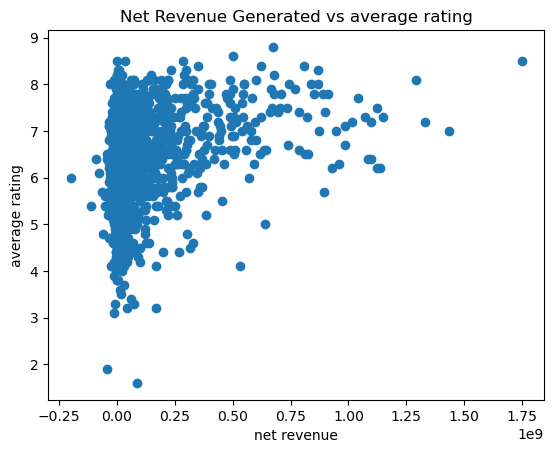

In [28]:
plt.scatter(info_budget_df['net_revenue'], info_budget_df['averagerating'])
plt.title('Net Revenue Generated vs average rating')
plt.xlabel('net revenue')
plt.ylabel('average rating')
plt.show()

The appears to be a relationship between net revenue and average rating. Let's explore the main KPI we've set - ROI%

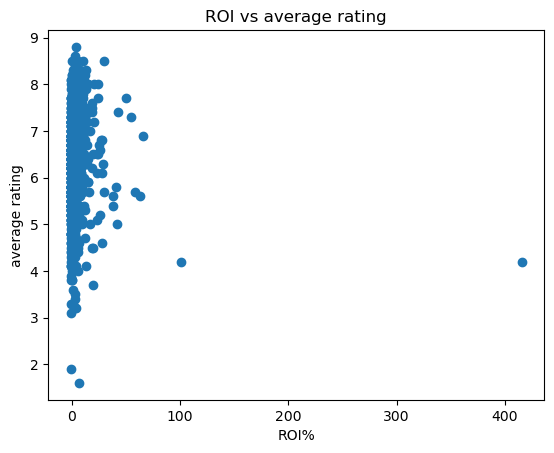

In [29]:
plt.scatter(info_budget_df['ROI%'], info_budget_df['averagerating'])
plt.title('ROI vs average rating')
plt.xlabel('ROI%')
plt.ylabel('average rating')
plt.show()

The outlier makes it tough to have a clear view. But we aren't sure that we should drop the outlier yet. We should focus on specific genres and their ROI first. 

Any given movie in the genre dataframe can have one or more genres associated with it. We will have to deal with this programmatically. But first, let's take a look at the potential genres.

In [31]:
# Split the genre cells at the comma and create an array of unique genres in the dataframe
all_genres = info_budget_df['genres'].str.split(',').explode()
unique_genres = all_genres.unique()
unique_genres

array(['Action', 'Adventure', 'Fantasy', 'Comedy', 'Biography', 'Drama',
       'Sport', 'Romance', 'Crime', 'Horror', 'Thriller', 'Family',
       'Sci-Fi', 'Mystery', 'History', 'Animation', 'Documentary', 'War',
       'Music', 'Musical', 'Western'], dtype=object)

In [32]:
# Write a function to place each movie into a dataframe for that genre
def create_genre_dataframe(df, genre):
    """
    Creates a dataframe containing only the rows where the specified genre is one of the genres.

    :param df: The original dataframe with movie data.
    :param genre: The genre to filter by.
    :return: A dataframe containing only rows with the specified genre.
    """
    # Filter rows where the genre column contains the specified genre
    genre_df = df[df['genres'].astype(str).str.contains(genre, na=False)]
    return genre_df

(There is probably a cleaner way to do this but I went through each genre manually to create a new dataframe)

In [33]:
horror_df = create_genre_dataframe(info_budget_df, 'Horror')
action_df = create_genre_dataframe(info_budget_df, 'Action')
adventure_df = create_genre_dataframe(info_budget_df, 'Adventure')
fantasy_df = create_genre_dataframe(info_budget_df, 'Fantasy')
scifi_df = create_genre_dataframe(info_budget_df, 'Sci-Fi')
thriller_df = create_genre_dataframe(info_budget_df, 'Thriller')
western_df = create_genre_dataframe(info_budget_df, 'Western')
animation_df = create_genre_dataframe(info_budget_df, 'Animation')
comedy_df = create_genre_dataframe(info_budget_df, 'Comedy')
family_df = create_genre_dataframe(info_budget_df, 'Family')
crime_df = create_genre_dataframe(info_budget_df, 'Crime')
drama_df = create_genre_dataframe(info_budget_df, 'Drama')
romance_df = create_genre_dataframe(info_budget_df, 'Romance')
mystery_df = create_genre_dataframe(info_budget_df, 'Mystery')
history_df = create_genre_dataframe(info_budget_df, 'History')
sports_df = create_genre_dataframe(info_budget_df, 'Sport')
biography_df = create_genre_dataframe(info_budget_df, 'Biography')
war_df = create_genre_dataframe(info_budget_df, 'War')
musical_df = create_genre_dataframe(info_budget_df, 'Musical')
documentary_df = create_genre_dataframe(info_budget_df, 'Documentary')
music_df = create_genre_dataframe(info_budget_df, 'Music')
news_df = create_genre_dataframe(info_budget_df, 'News')

In [34]:
# Create a dictionary for easy cleaning/handling in the future
# Genre is the key and genre dataframe is the value
genre_df_dict = {'Horror': horror_df, 'Action': action_df, 'Adventure': adventure_df, 'Fantasy': fantasy_df, 'Sci-Fi': scifi_df, 'Thriller': thriller_df,
       'Western': western_df, 'Animation': animation_df, 'Comedy': comedy_df, 'Family': family_df, 'Crime': crime_df, 'Drama': drama_df,
       'Romance': romance_df, 'Mystery': mystery_df, 'History': history_df, 'Sport': sports_df, 'Biography': biography_df, 'War': war_df,
       'Musical': musical_df, 'Documentary': documentary_df, 'Music': music_df, 'News': news_df}

In [62]:
# Save the Genre DFs to a directory in the Data folder
# Create the folder if it doesn't exist
if not os.path.exists("Data/genre_dfs"):
    os.makedirs("Data/genre_dfs")

for name, df in genre_df_dict.items():
    # Define the complete file path
    file_path = os.path.join("Data/genre_dfs", f"{name}.csv")
    
    # Save the dataframe to CSV
    df.to_csv(file_path, index=False)

In [35]:
# Create another dictionary for genre ROI
genre_ROI_df_dict= {'Horror': horror_df['ROI%'], 'Action': action_df['ROI%'], 'Adventure': adventure_df['ROI%'], 
                    'Fantasy': fantasy_df['ROI%'], 'Sci-Fi': scifi_df['ROI%'], 'Thriller': thriller_df['ROI%'], 
                    'Western': western_df['ROI%'], 'Animation': animation_df['ROI%'], 'Comedy': comedy_df['ROI%'], 
                    'Family': family_df['ROI%'], 'Crime': crime_df['ROI%'],
                    'Drama': drama_df['ROI%'], 'Romance': romance_df['ROI%'], 'Mystery': mystery_df['ROI%'], 
                    'History': history_df['ROI%'], 'Sport': sports_df['ROI%'],
                    'Biography': biography_df['ROI%'], 'War': war_df['ROI%'], 'Musical': musical_df['ROI%'], 
                    'Documentary': documentary_df['ROI%'], 'Music': music_df['ROI%'], 'News': news_df['ROI%']}

In [36]:
# Use a list comprehension to explore the top 15 most common genres
genre_count = [(genre, len(i)) for genre, i in genre_ROI_df_dict.items()]
genre_count.sort(key=lambda tup: tup[1], reverse=True)
top_15_genres = genre_count[:15]
top_15_genres

[('Drama', 753),
 ('Comedy', 511),
 ('Action', 440),
 ('Adventure', 358),
 ('Thriller', 274),
 ('Crime', 248),
 ('Romance', 195),
 ('Horror', 186),
 ('Sci-Fi', 147),
 ('Biography', 141),
 ('Mystery', 136),
 ('Fantasy', 127),
 ('Animation', 99),
 ('Family', 77),
 ('Music', 50)]

In [38]:
# Find each genre's average ROI
for x, y in genre_ROI_df_dict.items():
    average_roi = y.mean()
    print(f'{x}: {average_roi}')

Horror: 9.298232730826173
Action: 1.860011371896121
Adventure: 2.2026224561624628
Fantasy: 2.1065943894884724
Sci-Fi: 2.6018832911474656
Thriller: 5.720278250554301
Western: 0.38193258119384244
Animation: 2.958521739339202
Comedy: 2.3686602660052603
Family: 2.061976984211789
Crime: 1.0527215275990975
Drama: 2.330724692940332
Romance: 2.6448561309128333
Mystery: 9.282766285089451
History: 1.4098471332215325
Sport: 1.4554377914207526
Biography: 2.4789176916687357
War: 0.7546614552406627
Musical: 2.536316095324262
Documentary: 2.518073901365174
Music: 2.96211333537838
News: nan


# Analysis and Results

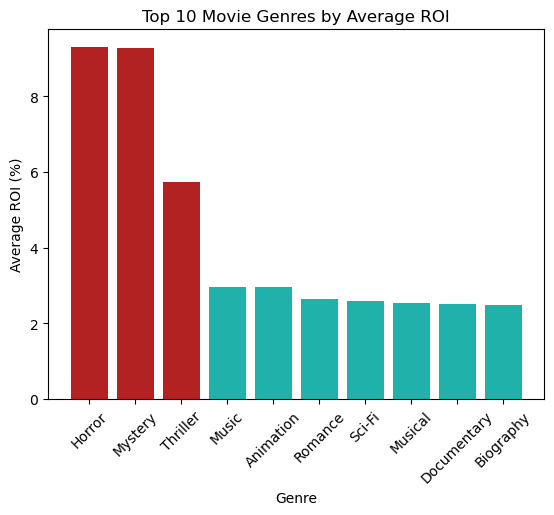

In [39]:
# Recalculate the average ROI for each genre and save it as a variable
genre_average_roi = {genre: df.mean() for genre, df in genre_ROI_df_dict.items()}

# Sort the genres by their average ROI in descending order and take the top 10
sorted_genre_average_roi = dict(
        sorted(genre_average_roi.items(),
        key=lambda item: item[1], reverse=True)[:10])

# Unpack the genres and their ROIs into separate lists
genres = list(sorted_genre_average_roi.keys())
average_rois = list(sorted_genre_average_roi.values())
colors = ['firebrick' if average_rois > 4 else 'lightseagreen' for average_rois in average_rois]

# Create a bar chart
plt.figsize=(10, 6)
plt.bar(genres, average_rois, color=colors)
plt.xlabel('Genre')
plt.ylabel('Average ROI (%)')
plt.title('Top 10 Movie Genres by Average ROI')
plt.xticks(rotation=45)
plt.show()

Horror, mystery, and thriller are clear favorites when it comes to mean ROI. But what about median, another measure of central tendency.

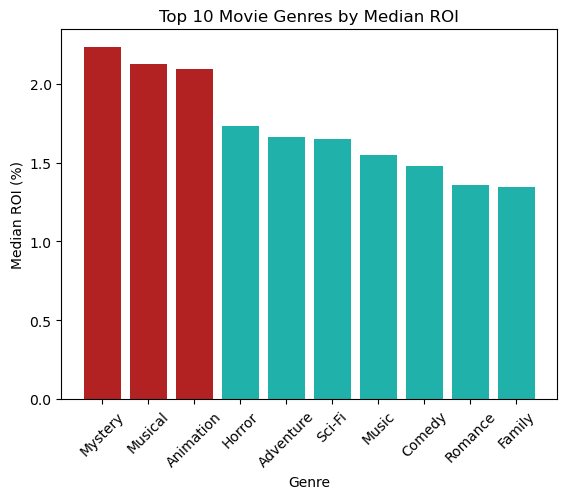

In [40]:
genre_median_roi = {genre: df.median() for genre, df in genre_ROI_df_dict.items()}
sorted_genre_median_roi = dict(sorted(genre_median_roi.items(), key=lambda item: item[1], reverse=True)[:10])
genres = list(sorted_genre_median_roi.keys())
median_rois = list(sorted_genre_median_roi.values())
colors = ['firebrick' if median_rois > 2 else 'lightseagreen' for median_rois in median_rois]

# Create a bar chart
plt.figsize=(10, 6)
plt.bar(genres, median_rois, color=colors)
plt.xlabel('Genre')
plt.ylabel('Median ROI (%)')
plt.title('Top 10 Movie Genres by Median ROI')
plt.xticks(rotation=45)
plt.show()

This provides a different view and shows that there are other genres that could be strong choices.

Now that we've found which movies are generally the best performers. We want to find out the recommended length of each film. Let's bucket the genres into two main categories, Light and Dark films, and investigate optimal runtimes.

In [41]:
# Filter for specific genres: Horror, Thriller, and Mystery
dark_genres_to_include = ['Horror', 'Thriller', 'Mystery']
dark_movies = info_budget_df[info_budget_df['genres'].str.contains('|'.join(dark_genres_to_include), na=False)]

# Calculate the maximum runtime for defining the upper limit of the bins
max_runtime = dark_movies['runtime_minutes'].max()

# Define runtime bins of 20 minutes each
bin_width = 20
bins = list(range(0, int(max_runtime) + bin_width, bin_width))

# Generate labels for the bins
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

# Bin the runtime data
dark_movies['runtime_bin'] = pd.cut(dark_movies['runtime_minutes'], bins=bins, labels=labels, include_lowest=True)

# Group by the new bins and calculate mean ROI
dark_grouped_data = dark_movies.groupby('runtime_bin', observed=True)['ROI%'].mean()

# Print the result
print(dark_grouped_data)

runtime_bin
60-80      5.082696
80-100     7.649524
100-120    3.025244
120-140    2.188443
140-160    2.060293
160-180    0.899972
Name: ROI%, dtype: float64


/var/folders/px/v7992sbn36q0sd74xlm965340000gn/T/ipykernel_11333/567716112.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dark_movies['runtime_bin'] = pd.cut(dark_movies['runtime_minutes'], bins=bins, labels=labels, include_lowest=True)


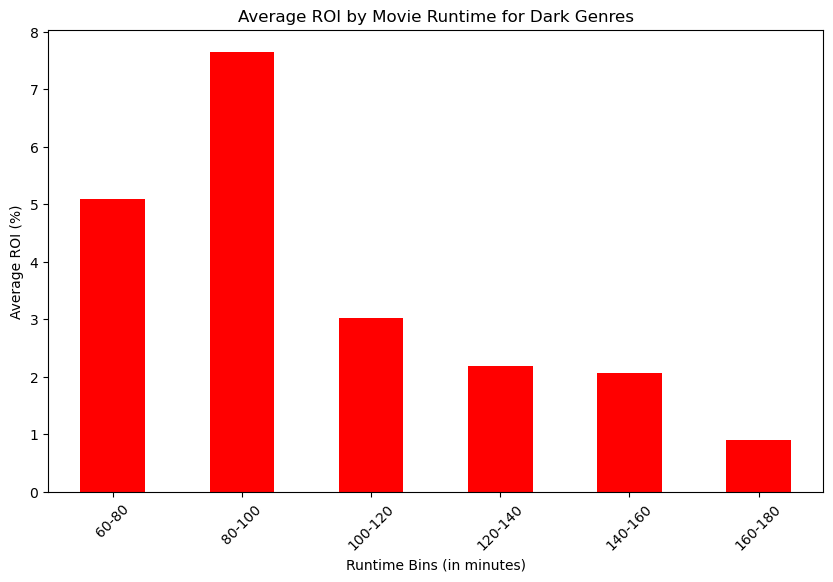

In [42]:
plt.figure(figsize=(10, 6))  # Set the figure size
dark_grouped_data.plot(kind='bar', color='red')  # Plot as a bar chart

# Adding titles and labels
plt.title('Average ROI by Movie Runtime for Dark Genres')
plt.xlabel('Runtime Bins (in minutes)')
plt.ylabel('Average ROI (%)')
plt.xticks(rotation=45)
# Show the plot
plt.show()

Dark movies see a better ROI when they are shorter and particularly in the 80-100 minute bin. What about Light films?

In [43]:
# Same for light genres
# Filter for specific genres: Musical, Animation, Family
light_genres_to_include = ['Musical', 'Animation', 'Family']
light_movies = info_budget_df[info_budget_df['genres'].str.contains('|'.join(light_genres_to_include), na=False)]

# Calculate the maximum runtime for defining the upper limit of the bins
light_max_runtime = light_movies['runtime_minutes'].max()

# Define runtime bins of 20 minutes each
bin_width = 20
bins = list(range(0, int(max_runtime) + bin_width, bin_width))

# Generate labels for the bins
labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

# Bin the runtime data
light_movies['runtime_bin'] = pd.cut(light_movies['runtime_minutes'], bins=bins, labels=labels, include_lowest=True)

# Group by the new bins and calculate mean ROI
light_grouped_data = light_movies.groupby('runtime_bin', observed=True)['ROI%'].mean()

# Print the result
print(light_grouped_data)

runtime_bin
60-80      2.103170
80-100     2.727941
100-120    2.258910
120-140    2.265440
140-160    5.123791
160-180    3.068014
Name: ROI%, dtype: float64


/var/folders/px/v7992sbn36q0sd74xlm965340000gn/T/ipykernel_11333/3905267674.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  light_movies['runtime_bin'] = pd.cut(light_movies['runtime_minutes'], bins=bins, labels=labels, include_lowest=True)


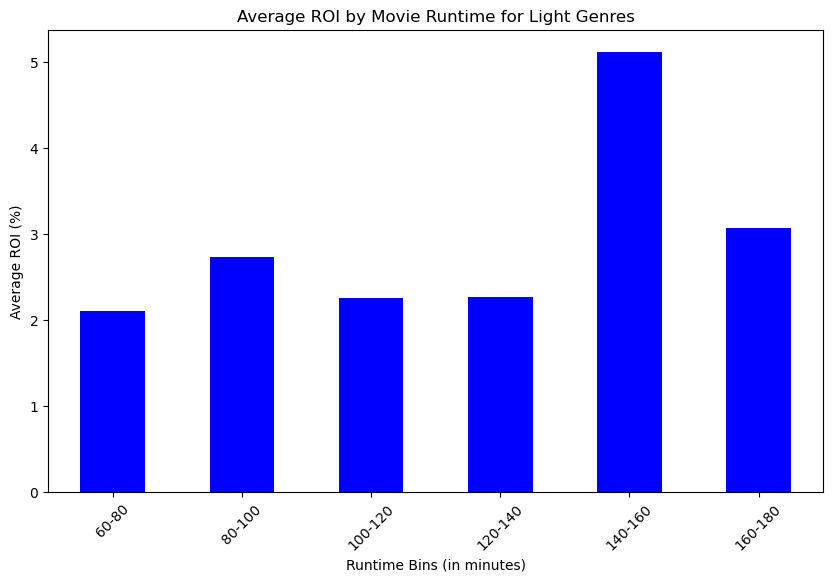

In [44]:
plt.figure(figsize=(10, 6))  # Set the figure size
light_grouped_data.plot(kind='bar', color='blue')  # Plot as a bar chart

# Adding titles and labels
plt.title('Average ROI by Movie Runtime for Light Genres')
plt.xlabel('Runtime Bins (in minutes)')
plt.ylabel('Average ROI (%)')
plt.xticks(rotation=45)
# Show the plot
plt.show()

Interesting, Light films perform better when they are longer. Lets place them next to each other for a comprehensive view.

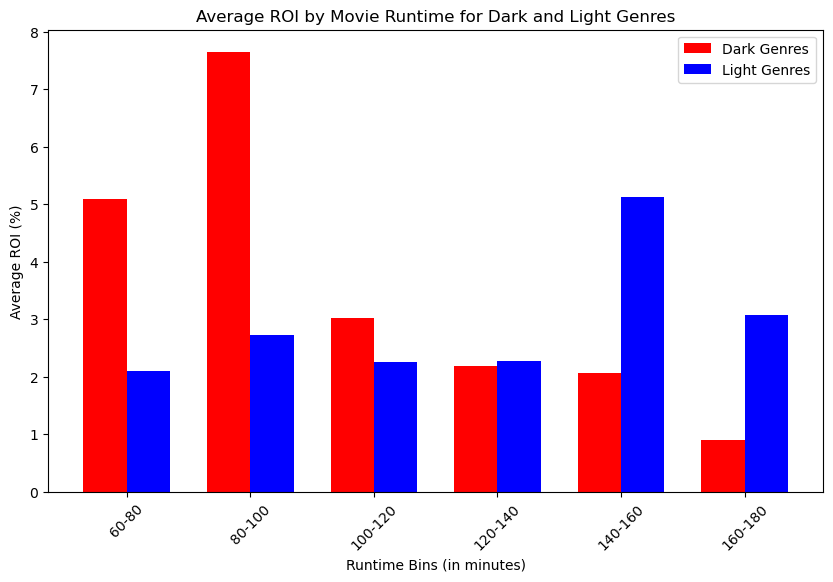

In [46]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the positions of the bars on the x-axis
n = len(dark_grouped_data)  # Number of data points (runtime bins)
ind = np.arange(n)  # the x locations for the groups
width = 0.35       # the width of the bars

# Create bars
plt.bar(ind - width/2, dark_grouped_data, width, color='red', label='Dark Genres')
plt.bar(ind + width/2, light_grouped_data, width, color='blue', label='Light Genres')

# Adding titles and labels
plt.title('Average ROI by Movie Runtime for Dark and Light Genres')
plt.xlabel('Runtime Bins (in minutes)')
plt.ylabel('Average ROI (%)')
plt.xticks(ind, dark_grouped_data.index, rotation=45)

# Add a legend
plt.legend()

# Show the plot
plt.show()

We will discuss this graph more in the analysis and results portion but the difference is clear. Light movies perform better when they are longer and dark movies when they are shorter. 

In [47]:
# Create a new dataframe only containing movies that fall under one of the selected genres
selected_movies = ['Musical', 'Animation', 'Family', 'Horror', 'Thriller', 'Mystery']
selected_movies_df = info_budget_df[info_budget_df['genres'].apply(lambda x: any(genre in x.split(',') for genre in selected_movies))]

In [48]:
# Create a new column that categorizes a movie as Light or Dark or Other
def categorize_movie(genres):
    dark_genres = {'Horror', 'Thriller', 'Mystery'}
    light_genres = {'Animation', 'Family', 'Musical'}
    
    genres_set = set(genres.split(','))

    if genres_set & dark_genres:
        return 'Dark'
    elif genres_set & light_genres:
        return 'Light'
    else:
        return 'Other'

# Apply the function to create the 'movie_type' column
selected_movies_df['movie_type'] = selected_movies_df['genres'].apply(categorize_movie)

/var/folders/px/v7992sbn36q0sd74xlm965340000gn/T/ipykernel_11333/2498997907.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_movies_df['movie_type'] = selected_movies_df['genres'].apply(categorize_movie)


In [49]:
# Explore the new data frame
selected_movies_df.shape

(604, 11)

In [50]:
selected_movies_df['movie_type'].value_counts()

movie_type
Dark     431
Light    173
Name: count, dtype: int64

After the intial genre vs ROI investigation. Let's focus on the rating info of a film and it's expected ROI.

In [51]:
# Drop unnecessary columns
selected_movies_rating_volume_df = selected_movies_df.drop(columns = ['runtime_minutes', 'genres', 'production_budget', 'domestic_gross',
                                   'worldwide_gross', 'net_revenue'])

In [52]:
# Create individual dataframes for dark and light films
dark_movies_df = selected_movies_df.loc[selected_movies_df['movie_type'] == 'Dark']
light_movies_df = selected_movies_df.loc[selected_movies_df['movie_type'] == 'Light']

In [53]:
# Display info on each dataframe
print('Light movies:')
light_movie_slim_df = selected_movies_rating_volume_df[selected_movies_rating_volume_df['movie_type'] == 'Light']
display(light_movie_slim_df.describe())
print('\n----------------------\n')
print('Dark movies:')
dark_movie_slim_df = selected_movies_rating_volume_df[selected_movies_rating_volume_df['movie_type'] == 'Dark']
display(dark_movie_slim_df.describe())

Light movies:


,averagerating,numvotes,ROI%
count,173.000000,173.000000,173.000000
mean,6.457803,111587.751445,2.519230
std,1.054233,131432.050113,2.829798
min,1.900000,5159.000000,-1.000000
25%,6.000000,23711.000000,0.797919
50%,6.600000,59486.000000,1.697980
75%,7.200000,146858.000000,3.331246
max,8.400000,719629.000000,14.680219



----------------------

Dark movies:


,averagerating,numvotes,ROI%
count,431.000000,4.310000e+02,431.000000
mean,6.164037,1.138290e+05,4.926551
std,0.902803,1.463874e+05,22.156101
min,3.200000,5.156000e+03,-1.000000
25%,5.600000,3.093750e+04,-0.338668
50%,6.200000,6.630300e+04,1.207960
75%,6.800000,1.271870e+05,3.452211
max,8.400000,1.387769e+06,415.564740


In [54]:
# Create a column that makes number of votes more readable
selected_movies_rating_volume_df['numvotes_thousands'] = selected_movies_rating_volume_df['numvotes'] / 1000

In [55]:
selected_movies_rating_volume_df['numvotes_thousands'].describe()

count     604.000000
mean      113.187038
std       142.160516
min         5.156000
25%        28.738500
50%        63.544000
75%       140.813000
max      1387.769000
Name: numvotes_thousands, dtype: float64

/var/folders/px/v7992sbn36q0sd74xlm965340000gn/T/ipykernel_11333/3351167112.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.swarmplot(
/var/folders/px/v7992sbn36q0sd74xlm965340000gn/T/ipykernel_11333/3351167112.py:12: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.swarmplot(


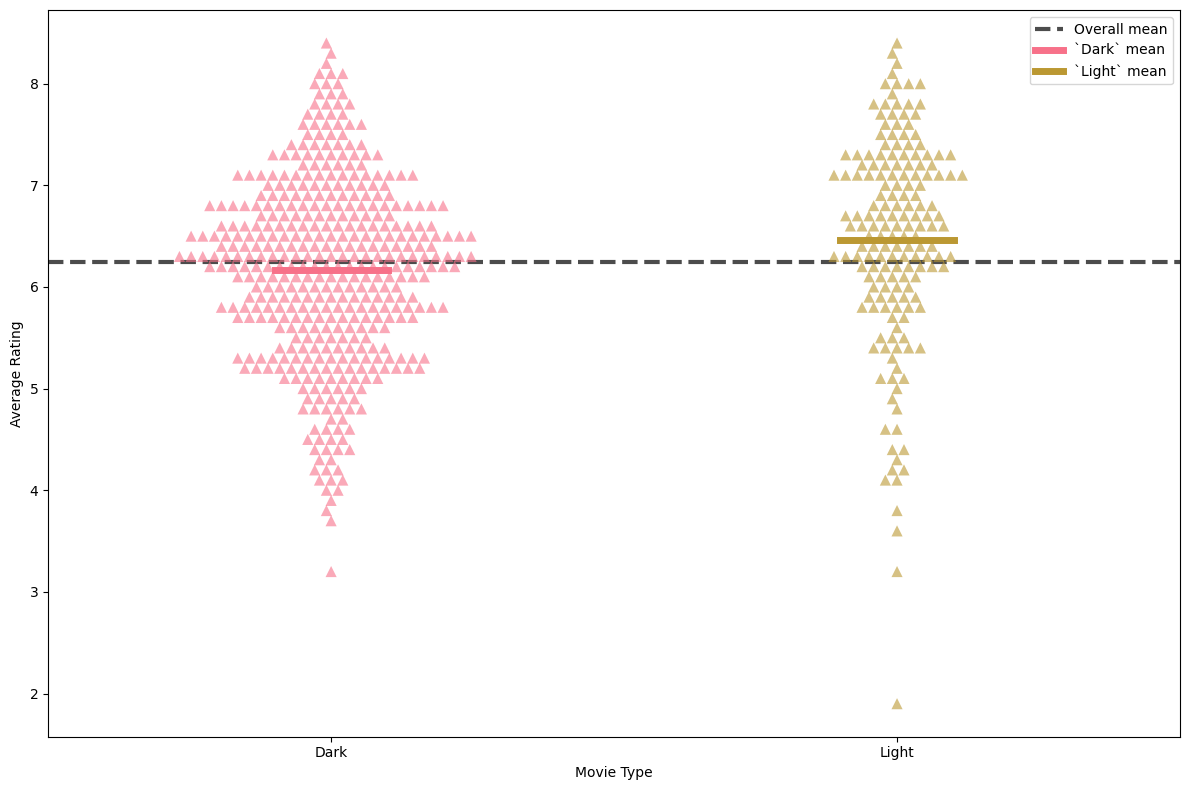

In [57]:
# Compare the rating info across film types using a swarm plot
f, ax = plt.subplots(figsize=(12, 8))

# Use specific set of colors
colors = sns.color_palette('husl')

# Select only two areas
selection_mask = (selected_movies_rating_volume_df['movie_type'] == 'Light')| (selected_movies_rating_volume_df['movie_type'] == 'Dark')
data_subset = selected_movies_rating_volume_df[selection_mask]

# Data Points
ax = sns.swarmplot(
    data=data_subset,
    x="movie_type",
    y="averagerating",
    ax=ax,
    alpha=0.6, 
    marker='^',
    size=8,
    palette=colors
)

ax.axhline(
    selected_movies_rating_volume_df['averagerating'].mean(), label='Overall mean',
    lw=3, ls='--', color='black', alpha=0.7
)

ax.set_xlabel('Movie Type')
ax.set_ylabel('Average Rating')

# Look at each specifc group (by area)
movie_type = data_subset['movie_type'].unique()
for i, movie_type in enumerate(movie_type):
    mean = selected_movies_rating_volume_df[selected_movies_rating_volume_df['movie_type']==movie_type]['averagerating'].mean()
    if i == 0:
        xmin = .2
        xmax = .3
    else:
        xmin = .7
        xmax = .8
    ax.axhline(
        mean, xmin=xmin, xmax=xmax, label=f'`{movie_type}` mean',
        lw=5, ls='-', color=colors[i]
    ) 

ax.legend()
plt.tight_layout();

It looks like dark and light films perform similarly well to each other in terms of average rating. Do rating and ROI have a relationship?

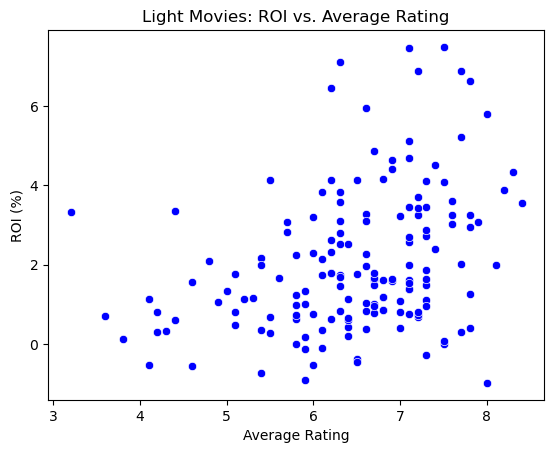

In [58]:
# Filter out the outliers
light_lower = light_movie_slim_df['ROI%'].quantile(0.01)
light_upper = light_movie_slim_df['ROI%'].quantile(0.95)
filtered_light_movie_slim_df = light_movie_slim_df[~((light_movie_slim_df['ROI%'] < light_lower) | (light_movie_slim_df['ROI%'] > light_upper))]

plt.figsize=(10, 8)
sns.scatterplot(x='averagerating', y='ROI%', data=filtered_light_movie_slim_df, color='blue')
plt.title('Light Movies: ROI vs. Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('ROI (%)')
plt.show()

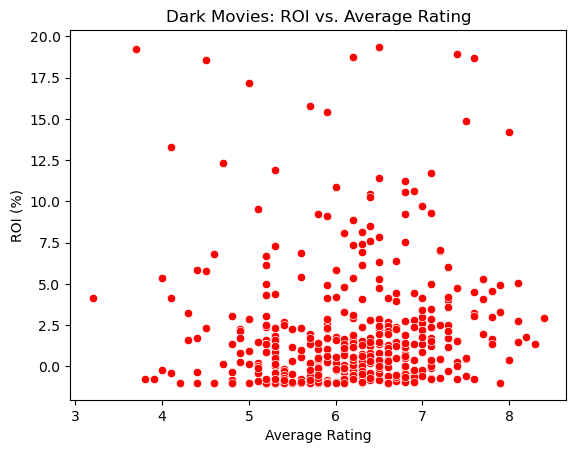

In [59]:
# Filter out the outliers
dark_lower = dark_movie_slim_df['ROI%'].quantile(0.01)
dark_upper = dark_movie_slim_df['ROI%'].quantile(0.95)

filtered_dark_movie_slim_df = dark_movie_slim_df[~((dark_movie_slim_df['ROI%'] < dark_lower) | (dark_movie_slim_df['ROI%'] > dark_upper))]

plt.figsize=(10, 8)
sns.scatterplot(x='averagerating', y='ROI%', data=filtered_dark_movie_slim_df, color='red')
plt.title('Dark Movies: ROI vs. Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('ROI (%)')
plt.show()

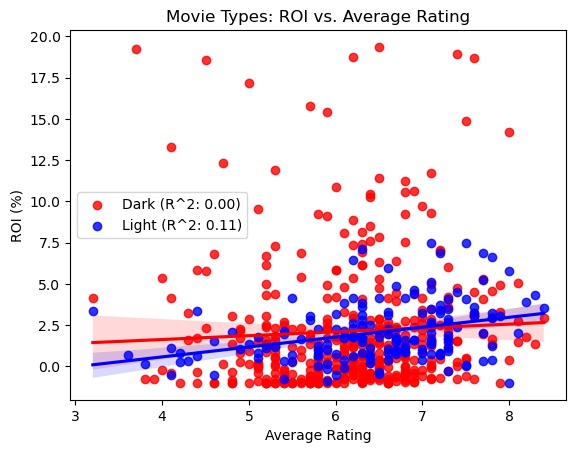

In [60]:
# Calculate correlation coefficients
r2_dark2 = (filtered_dark_movie_slim_df['averagerating'].corr(filtered_dark_movie_slim_df['ROI%']))**2
r2_light2 = (filtered_light_movie_slim_df['averagerating'].corr(filtered_light_movie_slim_df['ROI%']))**2

# Create scatter plots with regression lines
sns.regplot(x='averagerating', y='ROI%', data=filtered_dark_movie_slim_df, color='red', label=f'Dark (R^2: {r2_dark2:.2f})')
sns.regplot(x='averagerating', y='ROI%', data=filtered_light_movie_slim_df, color='blue', label=f'Light (R^2: {r2_light2:.2f})')

# Setting plot title and labels
plt.title('Movie Types: ROI vs. Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('ROI (%)')

# Show legend
plt.legend()

# Display the plot
plt.show()

### Business Recommendation 1

1. Two types of films: Dark Cinema and Light Cinema. 2.5 : 1 ratio dark to light for amount movies made for each category. Reflects dataset, industry norms.
- Dark: Horror, Thriller, Mystery
- Light: Musical, Animation, Family

### Business Recommendation 2

2. Movie length -
- Dark: 80-100 minutes
- Light: 140-160 minutes

### Business Recommendation 3

3. Movies don't have to be well liked or have a lot of reviews to make money
- No correlation between rating info and ROI
- Just churn out movies following guidelines above and we will see a profit over time
- Especially Dark Films (.02 corr coef for ROI vs Average Rating)

## Conclusion and Next Steps

- 10 year plan: after dozens of successful films, we can begin to make crossover films between the movie types to target an audience that watched light movies when they were younger but are older and have different tastes
- Research on franchises specifically
	- Do sequels of movies that perform well have higher ROI% than the normal film
- Further: naikling ndown specific percentages for movie creation